In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn

% matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('tsco_clean.csv')
data.head()

,Date,Open,High,Low,Close,Volume,next_close_is_high,next_close_is_low
0,31-Mar-17,188.55,190.12,185.55,185.60,23980231,-1,-1
1,30-Mar-17,189.35,192.15,188.20,189.00,17279065,0,1
2,29-Mar-17,191.90,191.90,189.22,190.25,16366596,0,1
3,28-Mar-17,190.00,192.00,188.00,191.20,21600784,0,1
4,27-Mar-17,189.75,190.55,187.55,189.95,12319546,1,0


In [3]:
data.describe()

,Open,High,Low,Close,Volume,next_close_is_high,next_close_is_low
count,4000.000000,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000
mean,309.560653,312.609585,305.802985,309.845920,2.930987e+07,0.487000,0.491750
std,86.138150,86.946273,85.699447,85.449562,5.136392e+07,0.500393,0.500494
min,-1.000000,-1.000000,-1.000000,139.200000,-1.000000e+00,-1.000000,-1.000000
25%,240.000000,242.750000,236.960000,240.000000,1.529005e+07,0.000000,0.000000
50%,318.750000,321.250000,315.535000,318.650000,2.311368e+07,0.000000,0.000000
75%,381.400000,385.650000,376.787500,381.512500,3.522399e+07,1.000000,1.000000
max,493.000000,494.250000,485.000000,492.000000,1.275697e+09,1.000000,1.000000


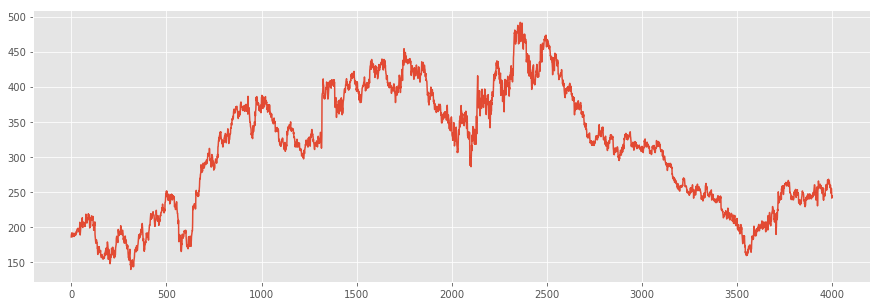

In [4]:
extract = data['Close']
plt.plot(extract.index, extract.values)
fig = plt.gcf()
fig.set_size_inches(15, 5)

In [5]:
n_input = 1
n_steps = 14
n_output = 7


learning_rate = 1e-3
n_epoch = 75
epoch_size = 200
n_hidden = 128
n_iter = n_epoch * epoch_size

In [6]:
time = list(range(n_steps, len(extract)-n_steps - n_output))
# Care when adding more values
past = np.empty((len(time), n_steps))
future = np.empty((len(time), n_output))

for i, v in enumerate(time):
    past[i,:] = extract[v-n_steps+1: v+1]
    future[i, :] = extract[v+1:v+n_output+1]

In [7]:
train_ratio = 0.9
train_size = int(len(past) * train_ratio)
break_global = time[train_size]
print('Train/Test Set Break: {}' .format(break_global))

train_past = past[:train_size]
train_past = train_past.reshape((len(train_past), n_steps, n_input))
train_future = future[:train_size]

test_past = past[train_size:]
test_past = test_past.reshape((len(test_past), n_steps, n_input))
test_future = future[train_size:]

Train/Test Set Break: 3582


In [8]:
def my_rnn(x, W, b):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_steps, axis=0)
    
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.nn.bias_add(tf.matmul(outputs[-1], W), b)

In [9]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_output])

W = tf.Variable(tf.truncated_normal([n_hidden, n_output]))
b = tf.Variable(tf.truncated_normal([n_output]))

h = my_rnn(x, W, b)

individual_losses = tf.reduce_sum(tf.squared_difference(h,y), reduction_indices=1)
loss = tf.reduce_mean(individual_losses)
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [10]:
#%%time 
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(n_iter+1):
    # No mini Batch yet
    optimiser.run(feed_dict={x:train_past, y:train_future})
    
    if iter% epoch_size ==0:
        print('Epoch: {} Loss: {}' .format(int(iter/epoch_size), loss.eval(feed_dict={x:train_past, y:train_future})))

Epoch: 0 Loss: 767119.875
Epoch: 1 Loss: 563636.25
Epoch: 2 Loss: 488049.5625
Epoch: 3 Loss: 425176.625
Epoch: 4 Loss: 370033.8125
Epoch: 5 Loss: 321406.125
Epoch: 6 Loss: 278556.78125
Epoch: 7 Loss: 240927.671875
Epoch: 8 Loss: 208050.453125
Epoch: 9 Loss: 177468.984375
Epoch: 10 Loss: 151060.171875
Epoch: 11 Loss: 128039.953125
Epoch: 12 Loss: 105900.3515625
Epoch: 13 Loss: 86284.46875
Epoch: 14 Loss: 70672.546875
Epoch: 15 Loss: 57472.59765625
Epoch: 16 Loss: 46123.18359375
Epoch: 17 Loss: 37300.890625
Epoch: 18 Loss: 30271.87109375
Epoch: 19 Loss: 24678.736328125
Epoch: 20 Loss: 20198.671875
Epoch: 21 Loss: 16540.517578125
Epoch: 22 Loss: 13509.7275390625
Epoch: 23 Loss: 11010.8447265625
Epoch: 24 Loss: 8972.6259765625
Epoch: 25 Loss: 7325.09033203125
Epoch: 26 Loss: 5996.9560546875
Epoch: 27 Loss: 4942.05712890625
Epoch: 28 Loss: 4007.788330078125
Epoch: 29 Loss: 3278.462158203125
Epoch: 30 Loss: 2716.156494140625
Epoch: 31 Loss: 2286.431884765625
Epoch: 32 Loss: 1951.072021484375

In [11]:
test_loss = loss.eval(feed_dict={x:test_past, y: test_future})
print('Test Loss: {}' .format(test_loss))

Test Loss: 485.10986328125


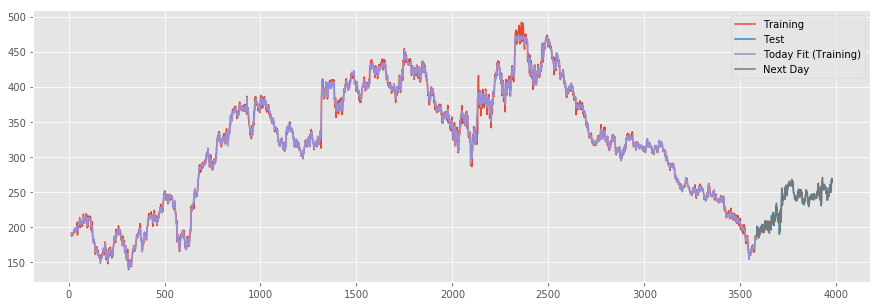

In [12]:
fit = h.eval(feed_dict={x:train_past})
pred = h.eval(feed_dict={x:test_past})
plt.plot(time[:train_size], past[:train_size, -1], label='Training')
plt.plot(time[train_size:], past[train_size:, -1], label='Test')
plt.plot(np.asarray(time[:train_size])+1, fit[:, 0], label='Today Fit (Training)')
plt.plot(np.asarray(time[train_size:])+1, pred[:,0], label='Next Day')
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.legend(loc=1)

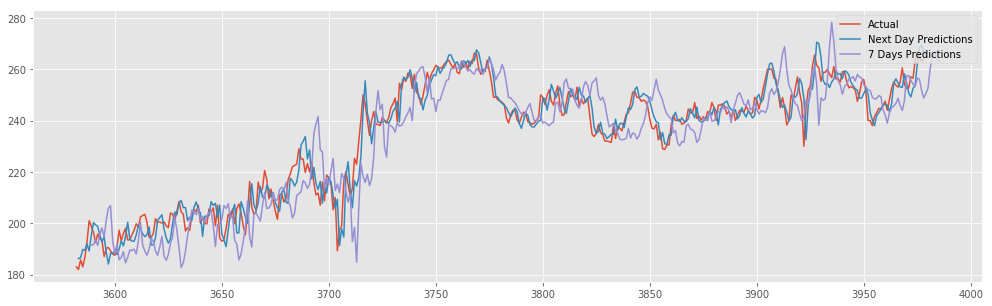

In [13]:
plt.plot(time[train_size:], past[train_size:, -1], label='Actual')
plt.plot(np.asarray(time[train_size:])+1, pred[:,0], label='Next Day Predictions')
plt.plot(np.asarray(time[train_size:])+7, pred[:,6], label='7 Days Predictions')
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.legend(loc=1)

Error Mean: -0.12808223695538806
Error STD: 2.663489522636818
RMSE: 2.011678354565983


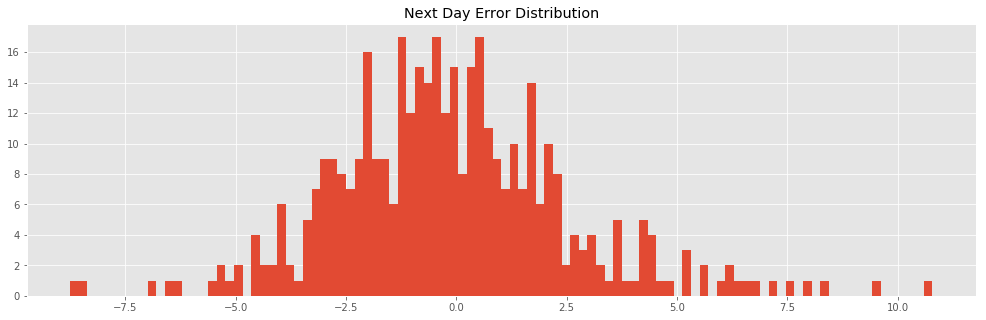

In [14]:
next_day_errors = past[train_size:, -1] - pred[:,0]
plt.hist(next_day_errors, 100)
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.title('Next Day Error Distribution')
print('Error Mean: {}' .format(np.mean(next_day_errors)))
print('Error STD: {}' .format(np.std(next_day_errors)))
print('RMSE: {}' .format(np.mean(np.absolute(next_day_errors))))

Delta STD: 4.415503511269683
Next Day Delta Mean: 3.287878787878788


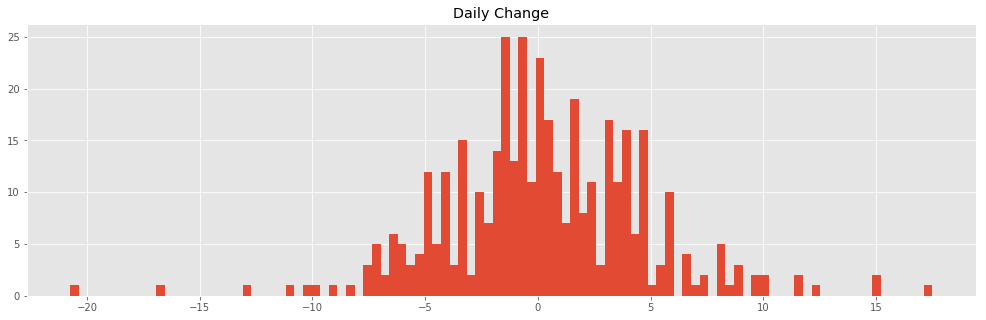

In [15]:
next_day_delta = past[train_size+1:, -1] - past[train_size+1:, -2]
ax = plt.hist(next_day_delta, 100)
fig = plt.gcf()
fig.set_size_inches(17, 5)
plt.title('Daily Change')
print('Delta STD: {}' .format(np.std(next_day_delta)))
print('Next Day Delta Mean: {}' .format(np.mean(np.absolute(next_day_delta))))